In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Cambria', 'Times New Roman']})

import seaborn as sns

In [3]:
%load_ext watermark

In [4]:
%watermark -h -v -m -p pandas,numpy,matplotlib

CPython 3.6.0
IPython 5.1.0

pandas 0.19.2
numpy 1.11.3
matplotlib 2.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 42 Stepping 7, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : user-PC


In [5]:
pd.options.display.max_rows = 8

### Load trades, determine price window for orders

In [6]:
h5root = '..\\h5 files\\'
chartdir = 'C:\\Users\\user\\Documents\\Agent-Based Models\\Charts\\'

In [7]:
h5subdir = 'TempTests\\'
h5file = 'smallcap_%d.h5' % 17

In [8]:
h5in = '%s%s%s' % (h5root, h5subdir, h5file)

In [9]:
trade_df = pd.read_hdf(h5in, 'trades')

In [10]:
window = 100
low_price = trade_df.price.min()-window
high_price = trade_df.price.max()+window
low_price, high_price, trade_df.price.max()-trade_df.price.min()

(999264, 999503, 39)

In [11]:
indf = pd.read_hdf(h5in, 'orders')
indf

,exid,order_id,price,quantity,replenish_size,reserve_size,side,timestamp,type,visible
0,99999999,p999999_a,1000590,1,0,0,sell,0,add,True
1,99999999,p999999_b,999335,1,0,0,buy,0,add,True
2,1,p33_1,999551,1,0,0,sell,1,add,True
3,2,p42_1,999498,1,0,0,sell,1,add,True
...,...,...,...,...,...,...,...,...,...,...
46066,2302106,m0_499765,999388,1,0,0,buy,100000,cancel,True
46067,2302107,m0_499837,999387,1,0,0,buy,100000,cancel,True
46068,2302108,m0_499902,999388,1,0,0,buy,100000,cancel,True
46069,2302109,m0_499912,999383,1,0,0,buy,100000,cancel,True


### Parse by side (buy vs. sell) and type (cancel vs. add)

In [12]:
add_buy_df = indf[(indf['type']=='add') & (indf['side']=='buy') & (indf['price']<2000000) & (indf['price']>low_price)]
add_sell_df = indf[(indf['type']=='add') & (indf['side']=='sell') & (indf['price']>0) & (indf['price']<high_price)]
cancel_buy_df = indf[(indf['type']=='cancel') & (indf['side']=='buy') & (indf['price']>low_price)]
cancel_sell_df = indf[(indf['type']=='cancel') & (indf['side']=='sell') & (indf['price']<high_price)]

#indf = indf[indf.timestamp<5000]
#add_buy_df = indf[(indf['type']=='add') & (indf['side']=='buy') & (indf['price']<2000000)]
#add_sell_df = indf[(indf['type']=='add') & (indf['side']=='sell') & (indf['price']>0)]
#cancel_buy_df = indf[(indf['type']=='cancel') & (indf['side']=='buy')]
#cancel_sell_df = indf[(indf['type']=='cancel') & (indf['side']=='sell')]

### groupby time and price, sum over quantity

In [13]:
add_buy_grp1 = add_buy_df.groupby(['timestamp', 'price']).quantity.sum()
cancel_buy_grp1 = cancel_buy_df.groupby(['timestamp', 'price']).quantity.sum()
add_sell_grp1 = add_sell_df.groupby(['timestamp', 'price']).quantity.sum()
cancel_sell_grp1 = cancel_sell_df.groupby(['timestamp', 'price']).quantity.sum()

### unstack by price, fill na with 0 and cumulate size over time

In [14]:
# add buy depth
add_buy_depth = add_buy_grp1.unstack(['price'])
add_buy_depth = add_buy_depth.reindex(index=pd.Index(np.arange(start=0, stop=100001, step=1)))
add_buy_depth.index.rename('timestamp', inplace=True)
add_buy_depth.fillna(value=0, inplace=True)
add_buy_depth_sumbytime = add_buy_depth.cumsum(axis=0)
add_buy_depth_sumbytime.sort_index(axis=1, ascending=False, inplace=True)

# cancel buy depth
cancel_buy_depth = cancel_buy_grp1.unstack(['price'])
cancel_buy_depth = cancel_buy_depth.reindex_like(add_buy_depth_sumbytime)
cancel_buy_depth.fillna(value=0, inplace=True)
cancel_buy_depth_sumbytime = cancel_buy_depth.cumsum(axis=0)

# add sell depth
add_sell_depth = add_sell_grp1.unstack(['price'])
add_sell_depth = add_sell_depth.reindex(index=pd.Index(np.arange(start=0, stop=100001, step=1)))
add_sell_depth.index.rename('timestamp', inplace=True)
add_sell_depth.fillna(value=0, inplace=True)
add_sell_depth_sumbytime = add_sell_depth.cumsum(axis=0)
add_sell_depth_sumbytime.sort_index(axis=1, inplace=True)

# cancel sell depth
cancel_sell_depth = cancel_sell_grp1.unstack(['price'])
cancel_sell_depth = cancel_sell_depth.reindex_like(add_sell_depth_sumbytime)
cancel_sell_depth.fillna(value=0, inplace=True)
cancel_sell_depth_sumbytime = cancel_sell_depth.cumsum(axis=0)

In [15]:
buy_depth1 = add_buy_depth_sumbytime - cancel_buy_depth_sumbytime
sell_depth1 = add_sell_depth_sumbytime - cancel_sell_depth_sumbytime

In [16]:
# trade side is from the incoming order
sell_trades_df = trade_df[trade_df['side']=='sell']
buy_trades_df = trade_df[trade_df['side']=='buy']

In [17]:
sell_trades_grp1 = sell_trades_df.groupby(['timestamp', 'price']).quantity.sum()
buy_trades_grp1 = buy_trades_df.groupby(['timestamp', 'price']).quantity.sum()

In [18]:
sell_trade_depth = sell_trades_grp1.unstack(['price'])
sell_trade_depth = sell_trade_depth.reindex_like(add_buy_depth_sumbytime)
sell_trade_depth.fillna(value=0, inplace=True)
sell_trade_depth_sumbytime = sell_trade_depth.cumsum(axis=0)

buy_trade_depth = buy_trades_grp1.unstack(['price'])
buy_trade_depth = buy_trade_depth.reindex_like(add_sell_depth_sumbytime)
buy_trade_depth.fillna(value=0, inplace=True)
buy_trade_depth_sumbytime = buy_trade_depth.cumsum(axis=0)

In [19]:
buy_depth = buy_depth1 - sell_trade_depth_sumbytime
buy_depth_mask = buy_depth>0
best_bid = buy_depth_mask.idxmax(axis=1)
sell_depth = sell_depth1 - buy_trade_depth_sumbytime
best_ask_mask = sell_depth>0
best_ask = best_ask_mask.idxmax(axis=1)
sell_depth = sell_depth.T
sell_depth.sort_index(ascending=False, inplace=True)
sell_depth = sell_depth.T

spread_df = pd.DataFrame({'best_bid': best_bid, 'best_ask': best_ask})
spread_df = spread_df.assign(spread = spread_df.best_ask - spread_df.best_bid)
spread_df

,best_ask,best_bid,spread
timestamp,,,
0,999367,999335,32
1,999498,999335,163
2,999383,999335,48
3,999383,999372,11
...,...,...,...
99997,999402,999400,2
99998,999401,999400,1
99999,999401,999400,1
100000,999401,999400,1


In [20]:
buy_depth1

price,999401,999400,999399,999398,999397,999396,999395,999394,999393,999392,...,999274,999273,999272,999271,999270,999269,999268,999267,999266,999265
timestamp,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99997,1.0,4.0,15.0,28.0,48.0,48.0,62.0,62.0,87.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,1.0,4.0,15.0,28.0,48.0,48.0,62.0,62.0,87.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99999,1.0,4.0,15.0,28.0,48.0,48.0,62.0,62.0,87.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100000,1.0,4.0,15.0,28.0,48.0,48.0,62.0,62.0,87.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
buy_max = buy_depth.max(axis=0)
buy_90 = buy_depth.quantile(q=.9, axis=0)
buy_max.sort_index(ascending=True, inplace=True)
sell_max = sell_depth.max(axis=0)
sell_90 = sell_depth.quantile(q=.9, axis=0)
sell_max.sort_index(ascending=True, inplace=True)

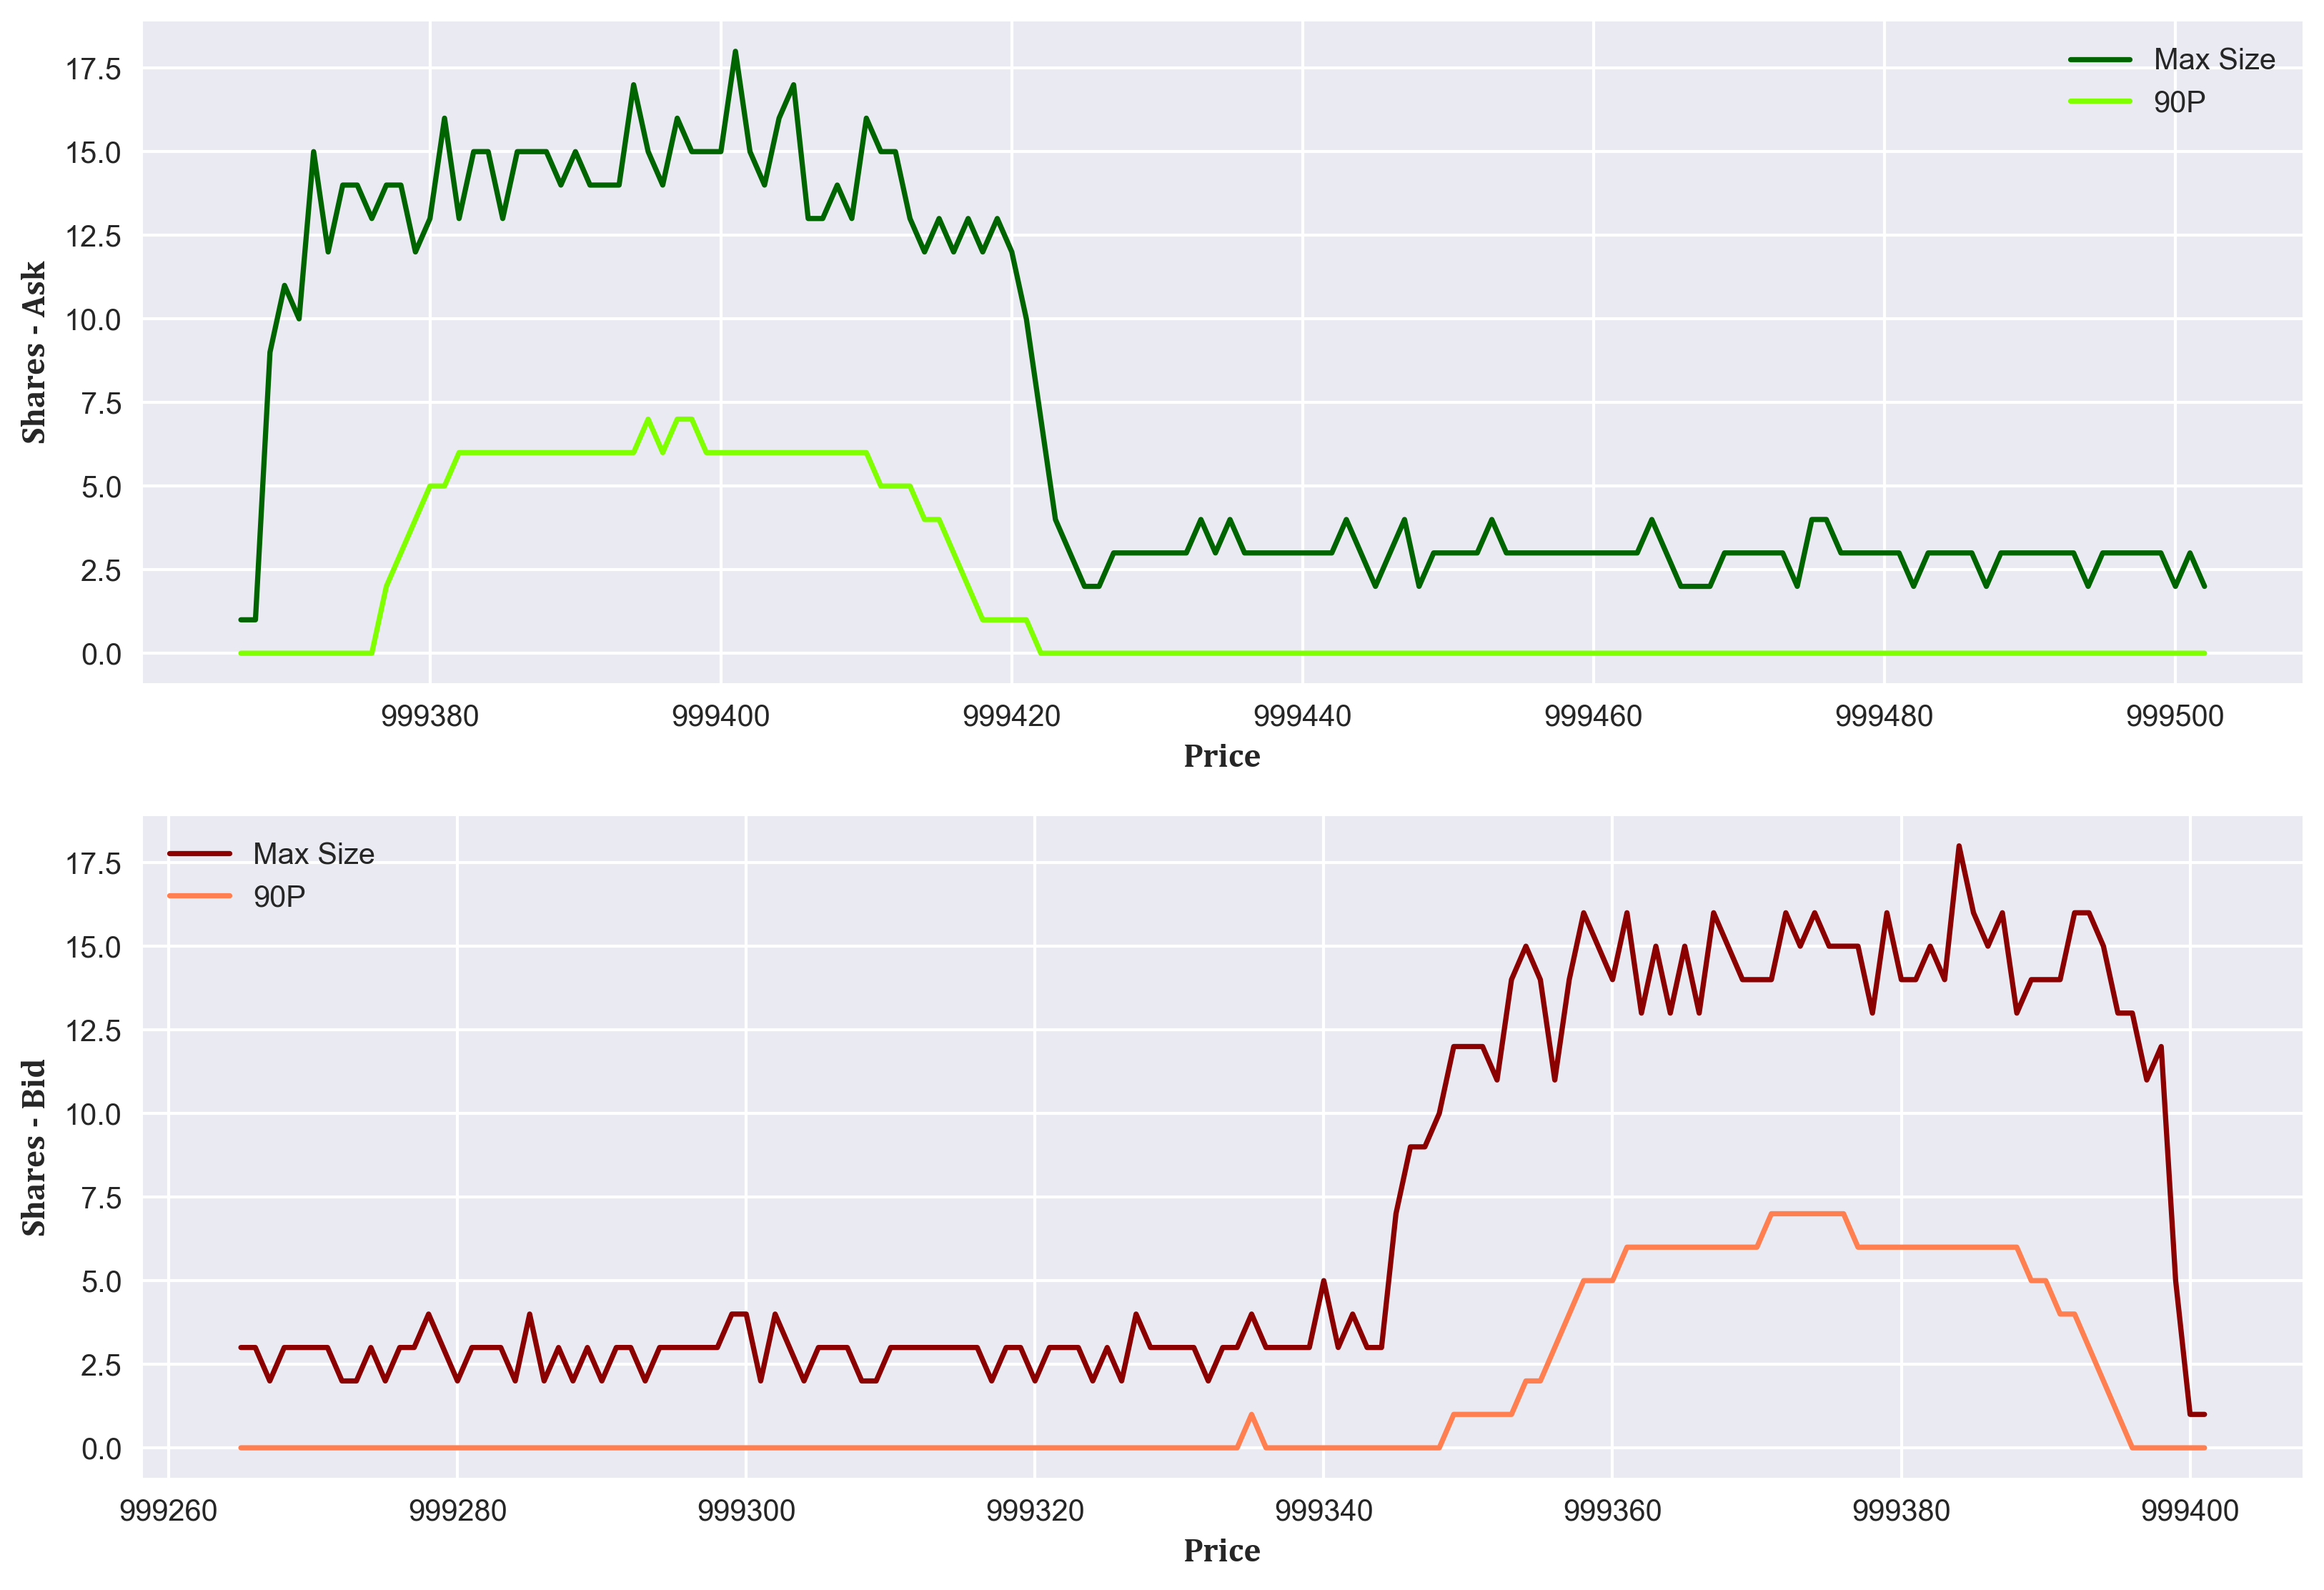

In [22]:
fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(211)
ax1.plot(sell_max, linestyle='solid', color='DarkGreen', marker='None', label='Max Size')
ax1.plot(sell_90, linestyle='solid', color='Chartreuse', marker='None', label='90P')
ax1.set_xlabel('Price', family='Cambria')
ax1.set_ylabel('Shares - Ask', family='Cambria')
ax1.legend(loc='upper right')
ax1 = fig.add_subplot(212)
ax1.plot(buy_max, linestyle='solid', color='DarkRed', marker='None', label='Max Size')
ax1.plot(buy_90, linestyle='solid', color='Coral', marker='None', label='90P')
ax1.set_xlabel('Price', family='Cambria')
ax1.set_ylabel('Shares - Bid', family='Cambria')
ax1.legend(loc='upper left')
fig.savefig('%smaxdepth.png' % chartdir)
plt.show()

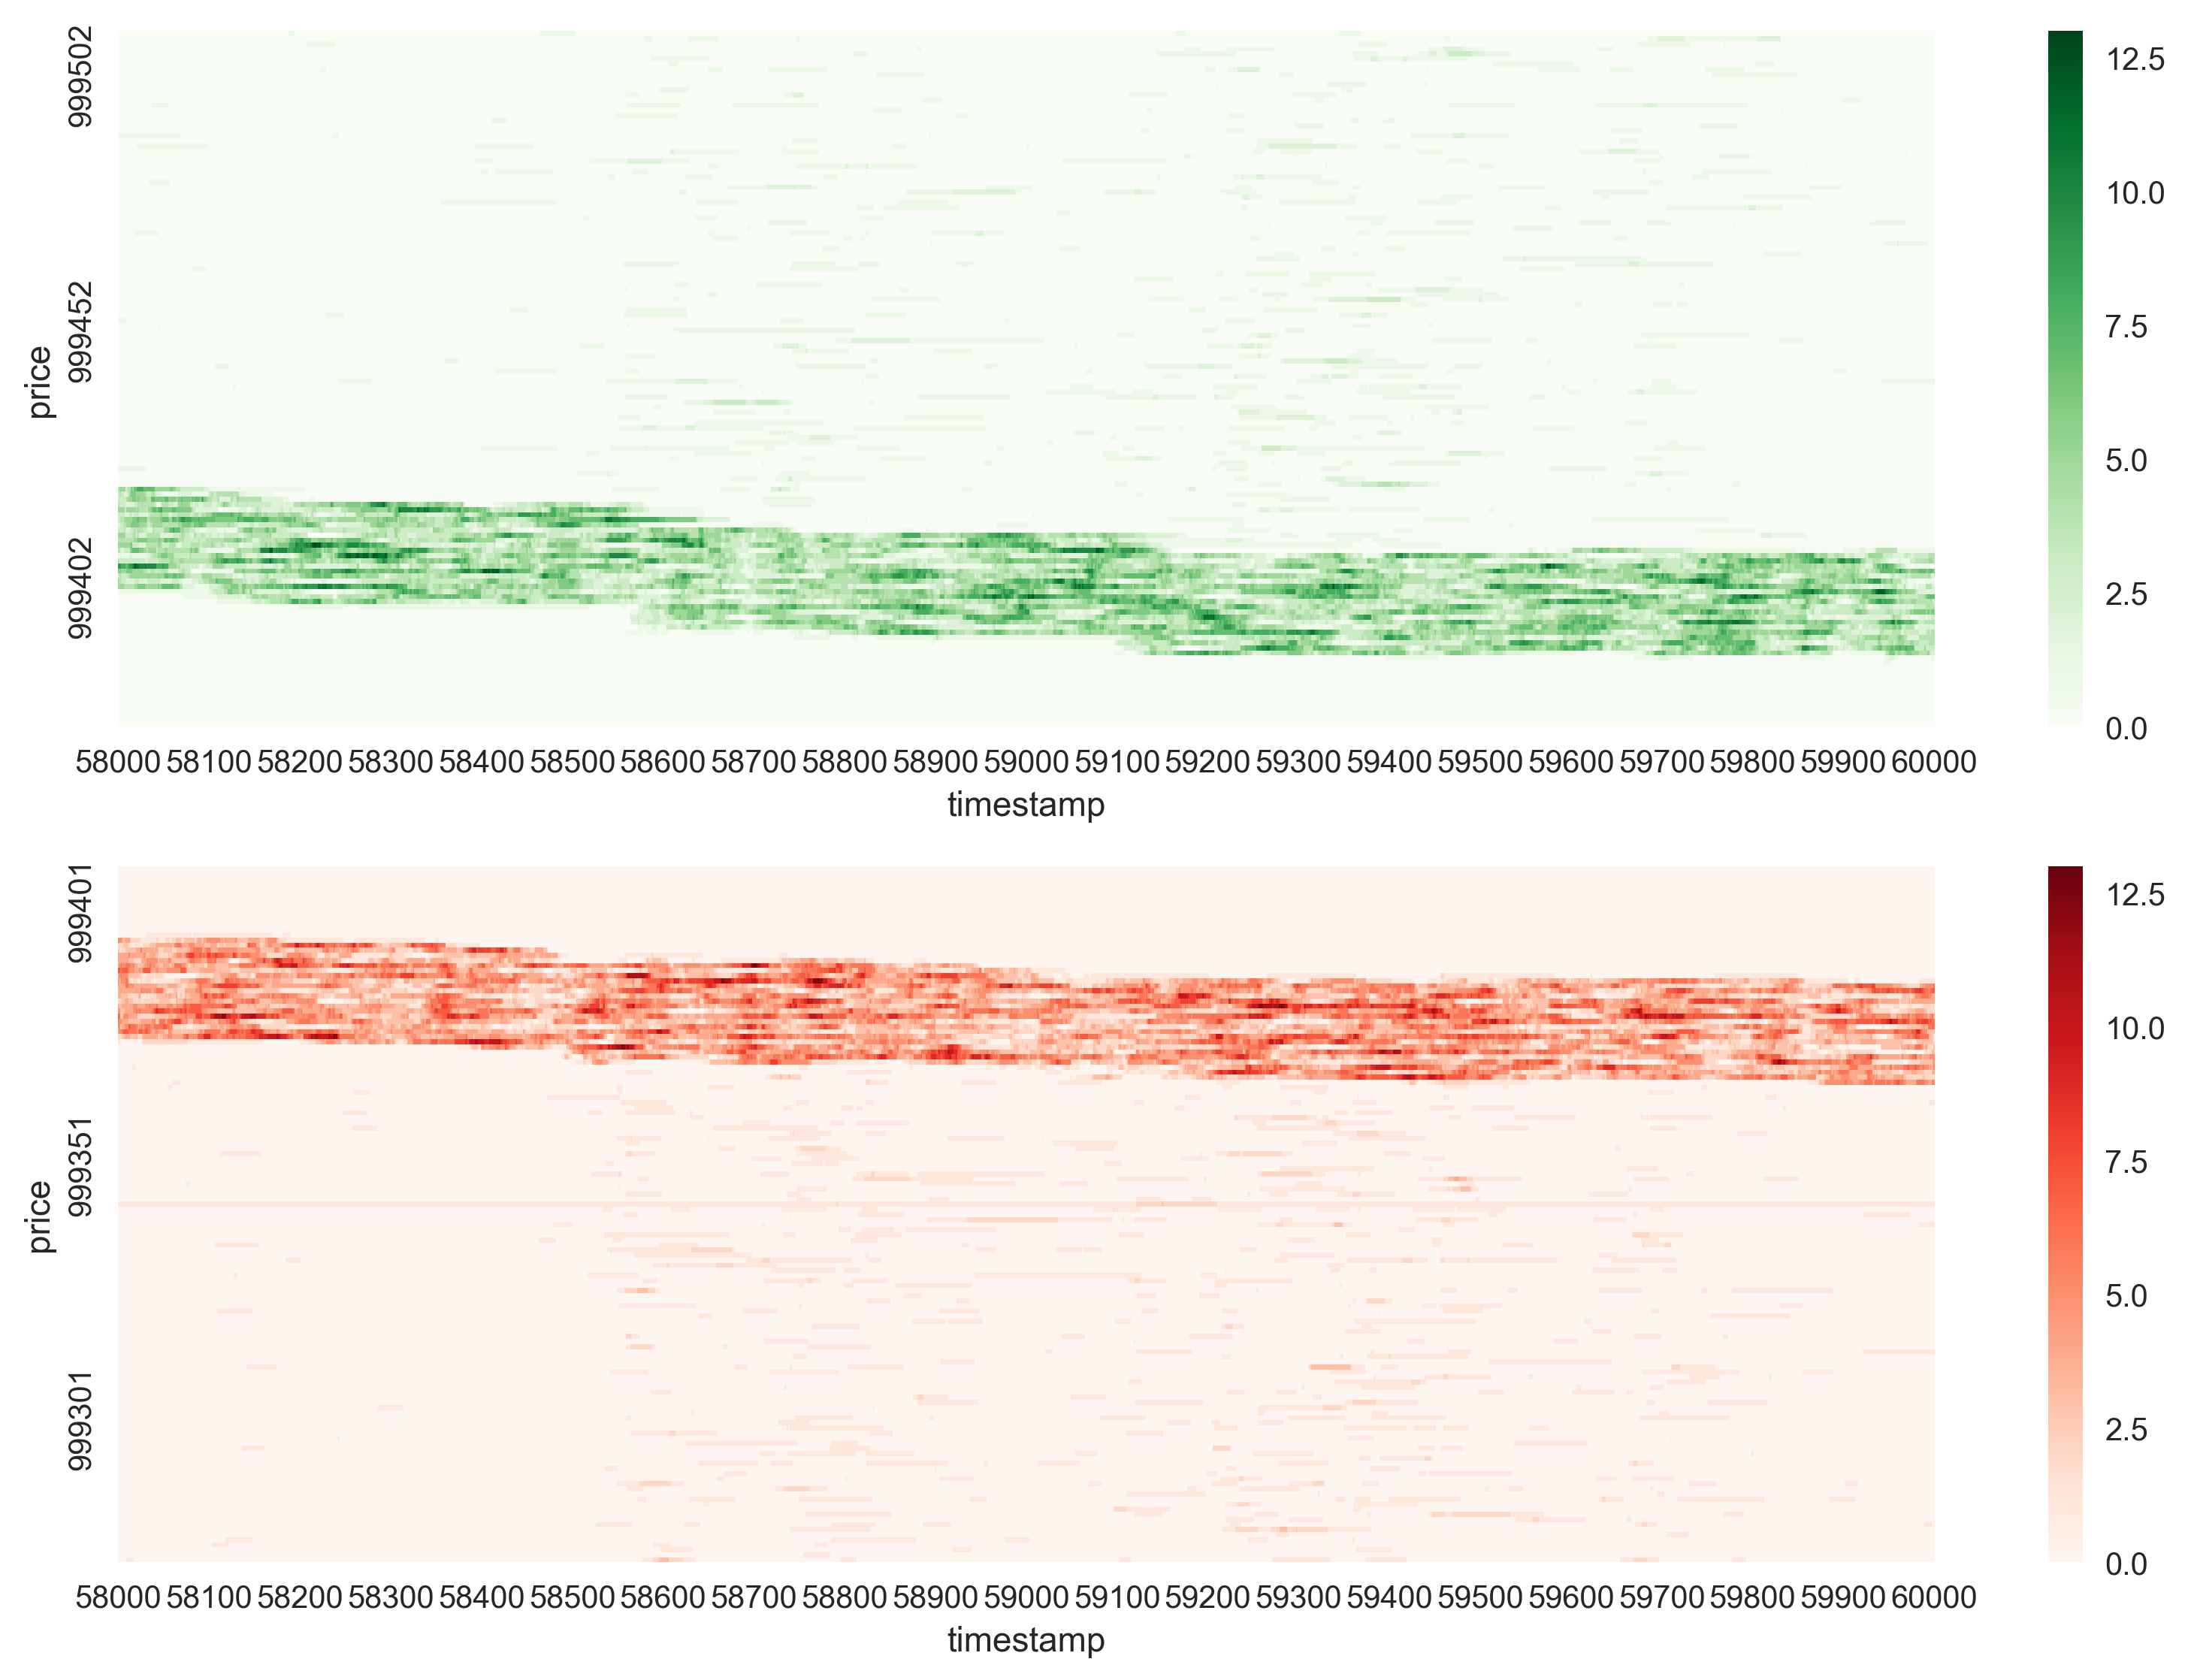

In [23]:
sell_depth_part = sell_depth.loc[58000:60000].T
buy_depth_part = buy_depth.loc[58000:60000].T

fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(211)
sns.heatmap(sell_depth_part, ax=ax1, xticklabels=100, yticklabels=50, cmap='Greens')
ax2 = fig.add_subplot(212)
sns.heatmap(buy_depth_part, ax=ax2, xticklabels=100, yticklabels=50, cmap='Reds')
plt.show()

In [24]:
sd = sell_depth_part.sum(axis=1)
min_sell = sd[sd>0].index.min()

bd = buy_depth_part.sum(axis=1)
max_buy = bd[bd>0].index.max()

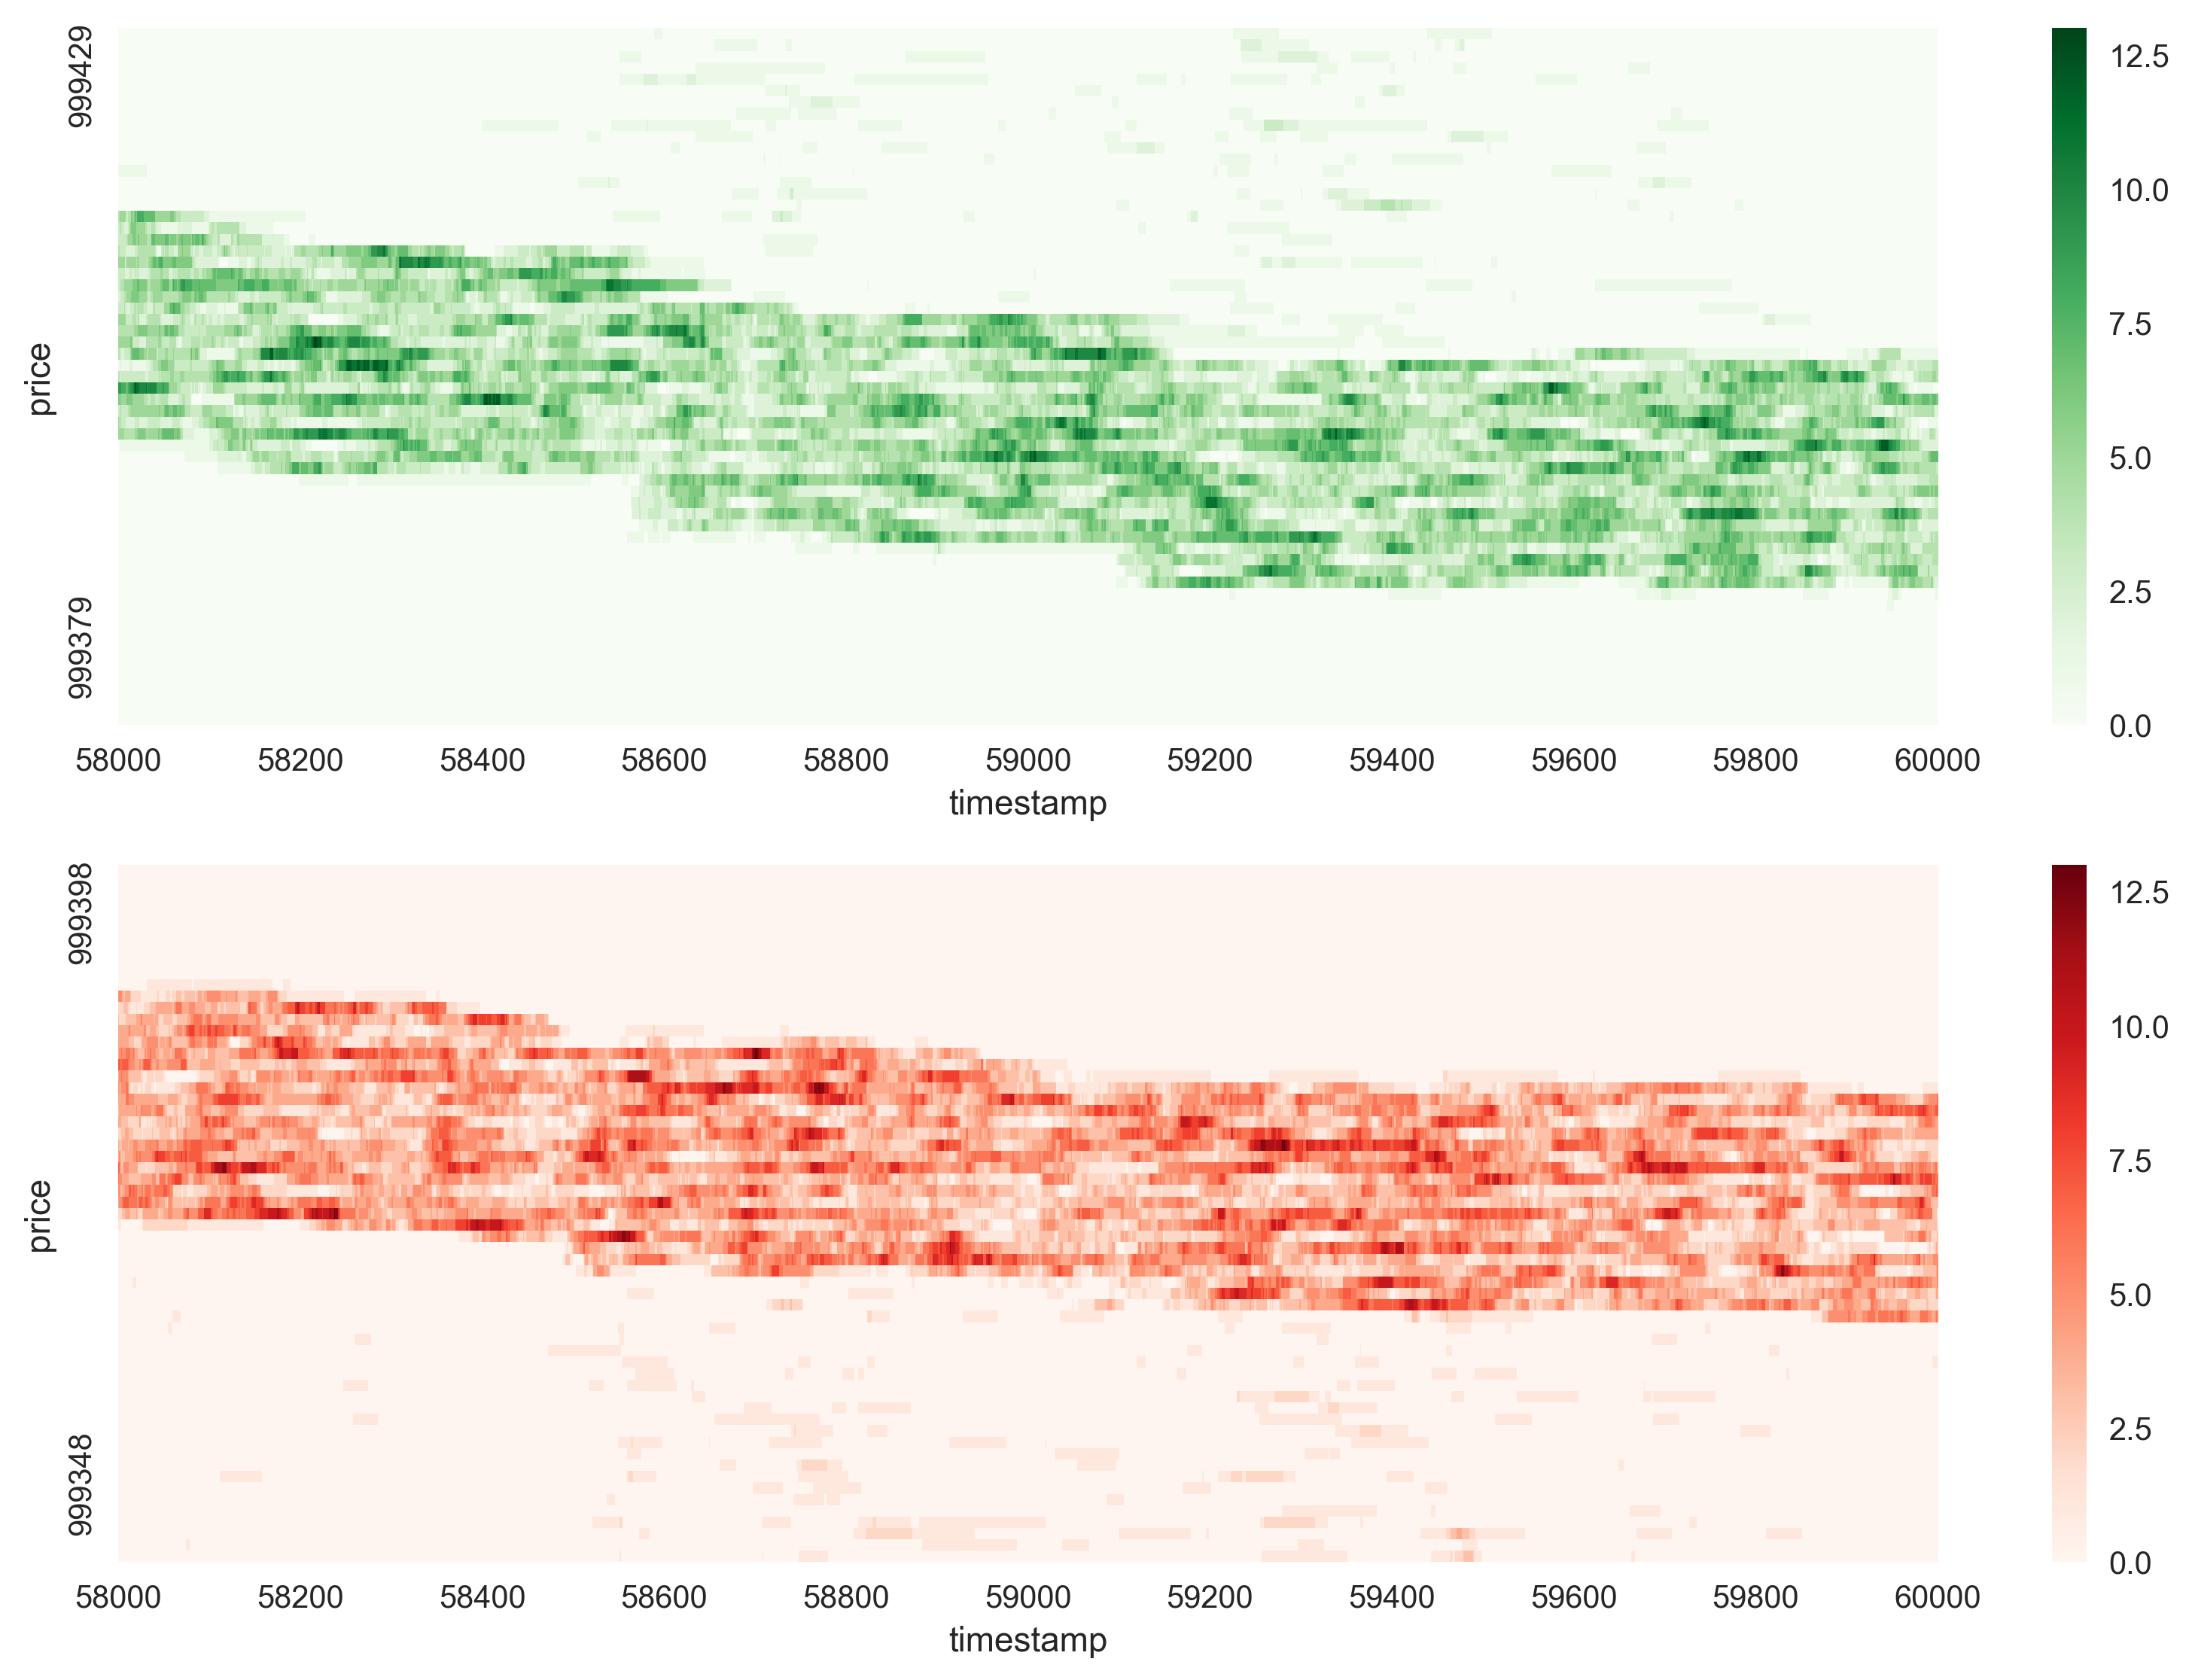

In [25]:
limit = 50

fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(211)
sns.heatmap(sell_depth_part.loc[min_sell+limit:min_sell-10], ax=ax1, xticklabels=200, yticklabels=50, cmap='Greens')
ax2 = fig.add_subplot(212)
sns.heatmap(buy_depth_part.loc[max_buy+10:max_buy-limit], ax=ax2, xticklabels=200, yticklabels=50, cmap='Reds')
fig.savefig('%sdepth.png' % chartdir)
plt.show()

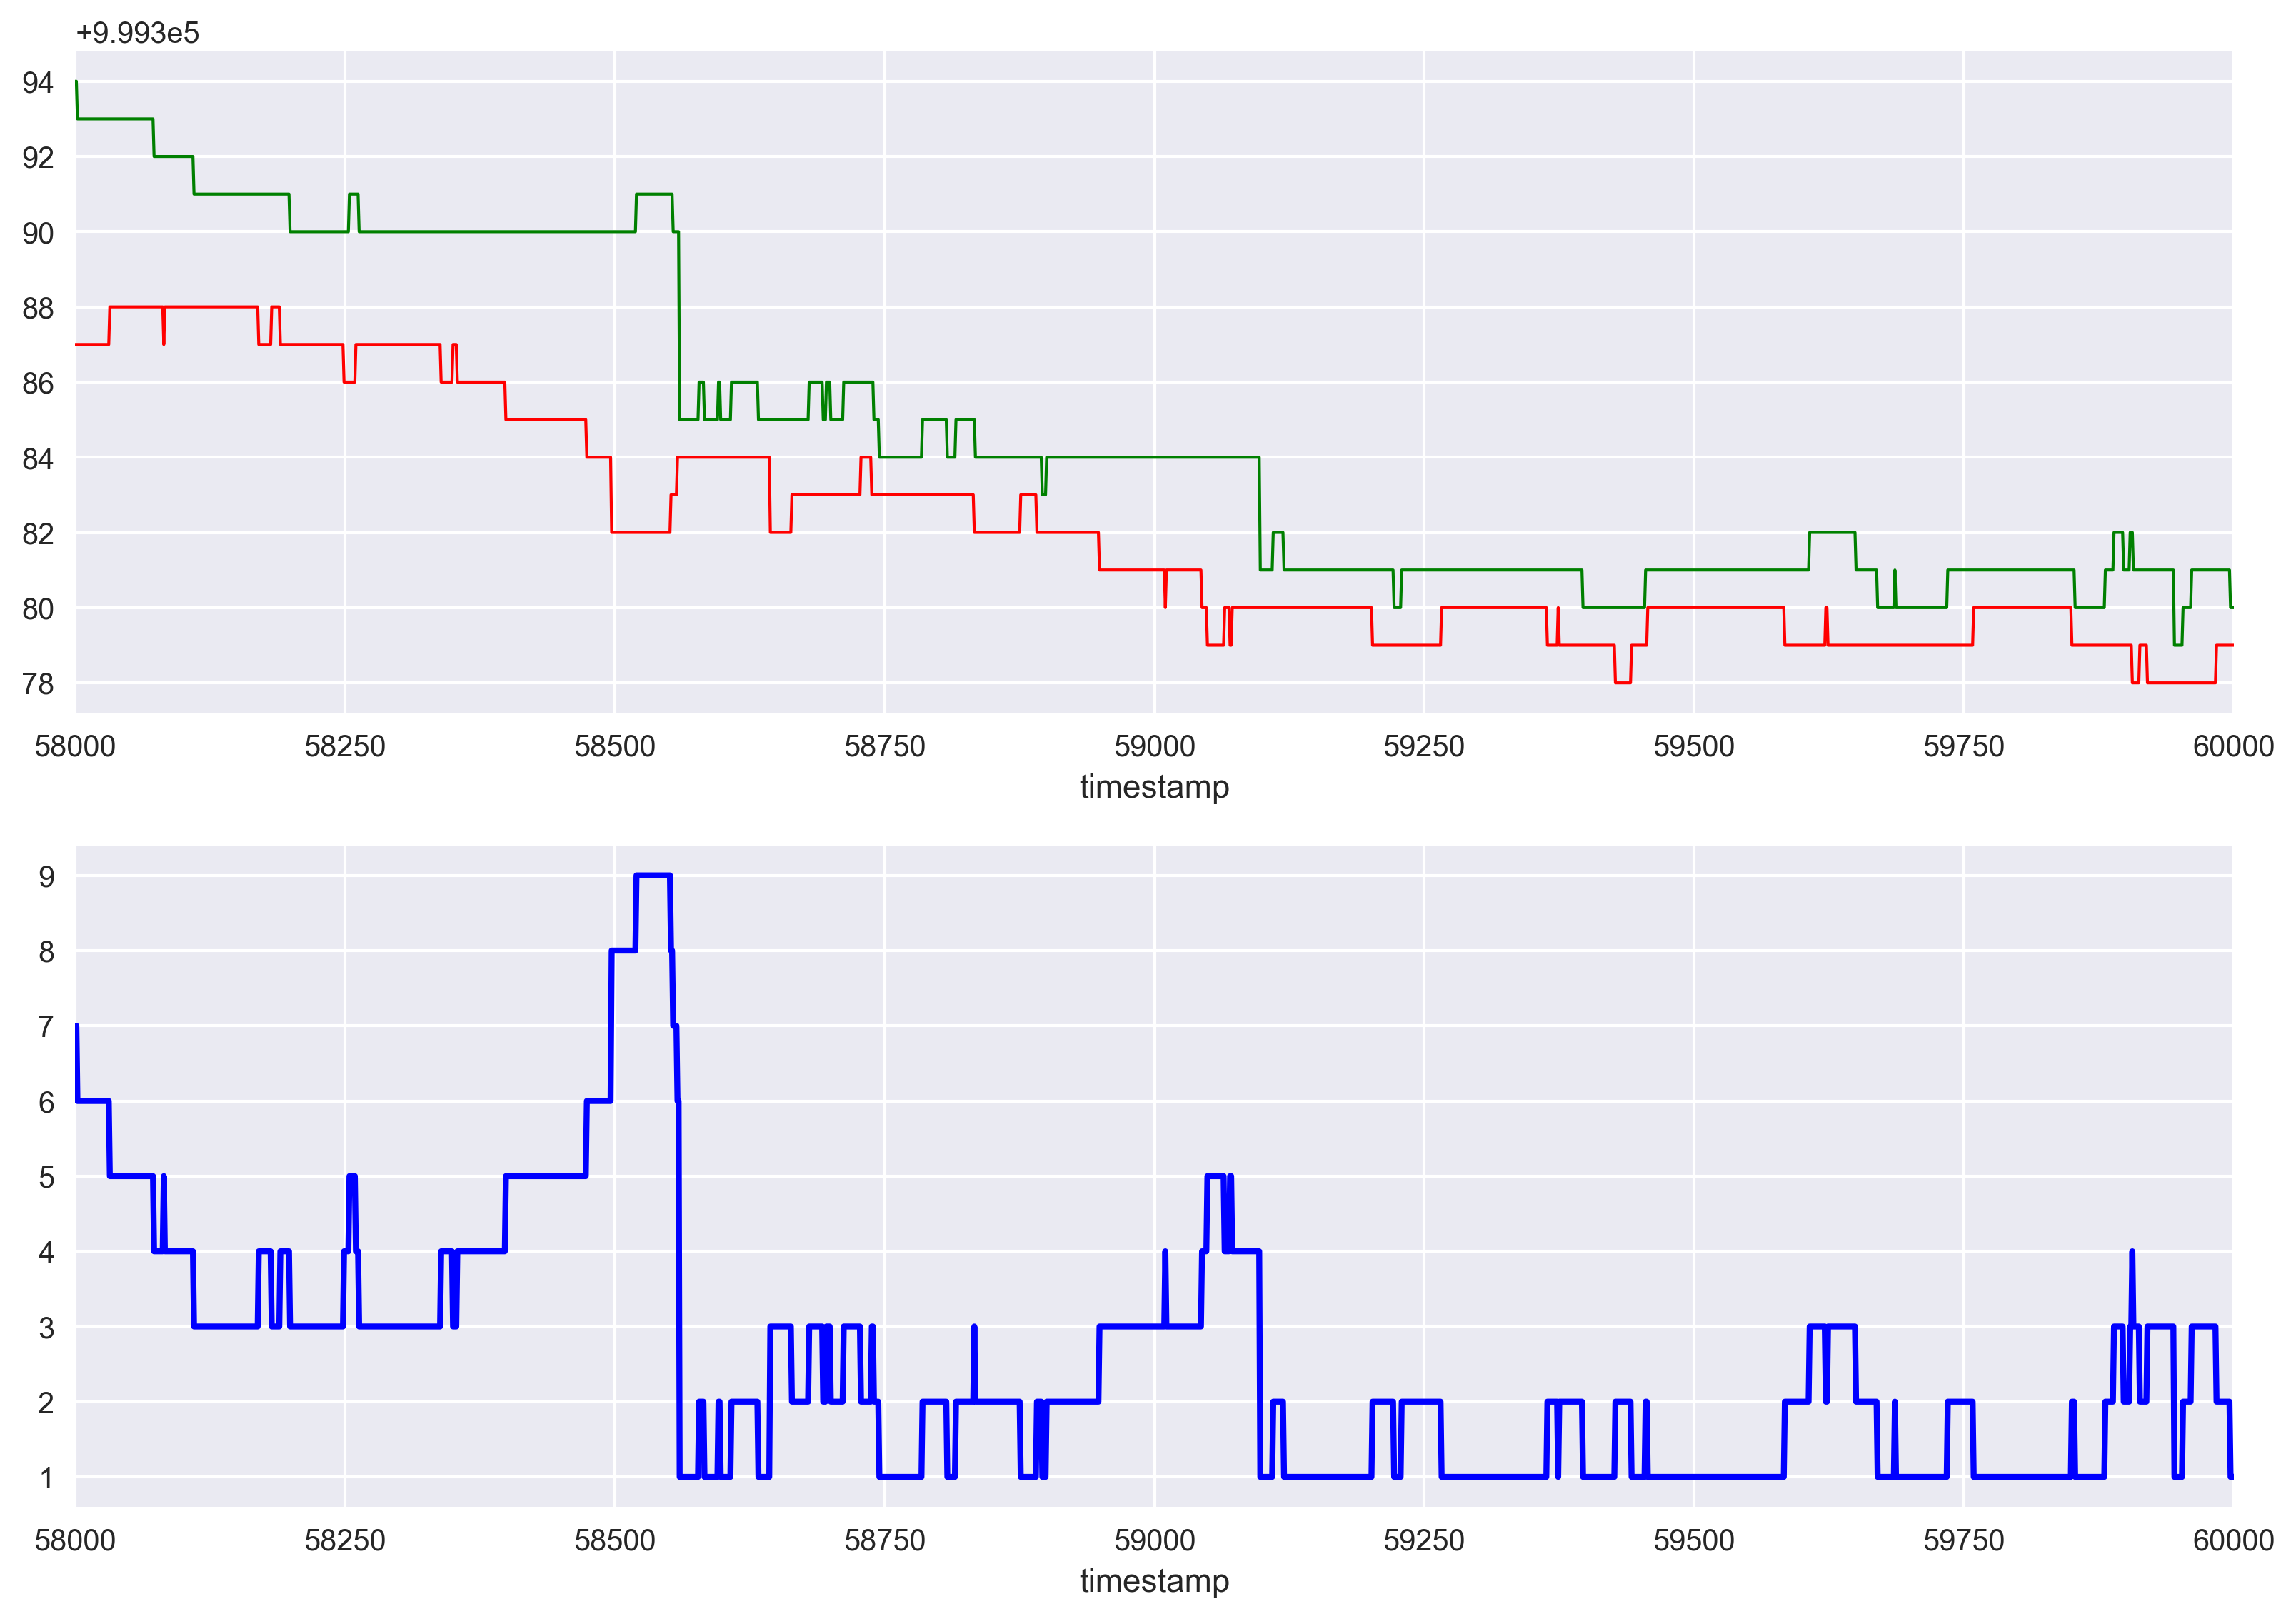

In [26]:
spread_df_plot = spread_df.loc[58000:60000]
fig = plt.figure(figsize=(13,9), dpi=300, facecolor='w')
ax1 = fig.add_subplot(211)
sns.tsplot(spread_df_plot.best_ask, ax=ax1, time=spread_df_plot.index, color='Green', lw=1)
sns.tsplot(spread_df_plot.best_bid, ax=ax1, time=spread_df_plot.index, color='Red', lw=1)
ax2 = fig.add_subplot(212)
sns.tsplot(spread_df_plot.spread, ax=ax2, time=spread_df_plot.index, color='Blue', lw=2)
fig.savefig('%sspread.png' % chartdir)
plt.show()

In [26]:
spread_df.loc[50:][['spread', 'best_bid', 'best_ask']].describe()

,spread,best_bid,best_ask
count,99951.000000,9.995100e+04,9.995100e+04
mean,14.973697,1.001547e+06,1.001562e+06
std,9.042173,6.676824e+01,6.795526e+01
min,1.000000,1.001419e+06,1.001430e+06
25%,8.000000,1.001504e+06,1.001518e+06
50%,13.000000,1.001538e+06,1.001552e+06
75%,20.000000,1.001589e+06,1.001608e+06
max,56.000000,1.001700e+06,1.001719e+06


### Jet plot prep

### Step 1: choose subset of data and resample to fill price gaps

In [27]:
start_time = 58000
end_time = 60000

part_buy_depth = buy_depth.loc[start_time:end_time].T
p_max = part_buy_depth.index[0]
p_min = part_buy_depth.index[-1]-1
new_index = range(p_max,p_min,-1)
pbd = part_buy_depth.reindex(index=new_index, fill_value=0).T

part_sell_depth = sell_depth.loc[start_time:end_time].T
p_max = part_sell_depth.index[0]
p_min = part_sell_depth.index[-1]-1
new_index = range(p_max,p_min,-1)
psd = part_sell_depth.reindex(index=new_index, fill_value=0).T

pbd, psd

(price      1001701  1001700  1001699  1001698  1001697  1001696  1001695  \
 timestamp                                                                  
 58000          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 58001          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 58002          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 58003          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 ...            ...      ...      ...      ...      ...      ...      ...   
 59997          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 59998          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 59999          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 60000          0.0      0.0      0.0      0.0      0.0      0.0      0.0   
 
 price      1001694  1001693  1001692   ...     1001330  1001329  1001328  \
 timestamp                              ...                               

### ask and bid depth dictionaries to DataFrames

In [28]:
bid_dict = {}
for t in range(start_time,end_time):
    bid_start = spread_df.loc[t].best_bid
    bid_end = bid_start-100
    bid_vals = pbd.loc[t, bid_start:bid_end].values
    bid_dict[t] = bid_vals

bid_df = pd.DataFrame(bid_dict)
bid_df = bid_df.cumsum(axis=0)
bid_df = bid_df.T
old_col_names = bid_df.columns
new_col_names = ['bid%d' % j for j in range(1,102)]
bid_df.rename(columns=dict(zip(old_col_names,new_col_names)), inplace=True)
bid_df

,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,...,bid92,bid93,bid94,bid95,bid96,bid97,bid98,bid99,bid100,bid101
58000,5.0,8.0,14.0,21.0,25.0,31.0,35.0,40.0,43.0,48.0,...,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
58001,5.0,8.0,14.0,21.0,25.0,31.0,35.0,40.0,43.0,48.0,...,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
58002,5.0,8.0,14.0,22.0,26.0,32.0,36.0,41.0,45.0,50.0,...,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0,85.0
58003,4.0,7.0,13.0,21.0,25.0,31.0,35.0,40.0,44.0,49.0,...,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,1.0,1.0,3.0,4.0,7.0,10.0,12.0,18.0,19.0,22.0,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
59997,1.0,1.0,3.0,4.0,7.0,9.0,11.0,17.0,18.0,20.0,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
59998,1.0,1.0,4.0,5.0,8.0,10.0,12.0,18.0,20.0,23.0,...,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0
59999,1.0,1.0,4.0,5.0,8.0,10.0,12.0,18.0,20.0,23.0,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0


In [29]:
ask_dict = {}
for t in range(start_time,end_time):
    ask_end = spread_df.loc[t].best_ask
    ask_start = ask_end+100
    ask_vals = psd.loc[t, ask_start:ask_end].values
    ask_dict[t] = ask_vals

ask_df = pd.DataFrame(ask_dict)
ask_df.sort_index(axis=0, ascending=False, inplace=True)
ask_df = ask_df.cumsum(axis=0)
ask_df = ask_df.T
old_col_names = ask_df.columns
new_col_names = ['ask%d' % j for j in range(1,102)]
ask_df.rename(columns=dict(zip(old_col_names,new_col_names)), inplace=True)
ask_df

,ask1,ask2,ask3,ask4,ask5,ask6,ask7,ask8,ask9,ask10,...,ask92,ask93,ask94,ask95,ask96,ask97,ask98,ask99,ask100,ask101
58000,4.0,4.0,7.0,7.0,10.0,11.0,13.0,17.0,21.0,23.0,...,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0,44.0
58001,4.0,4.0,6.0,6.0,9.0,10.0,12.0,16.0,20.0,22.0,...,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0
58002,3.0,3.0,5.0,5.0,8.0,9.0,11.0,15.0,19.0,21.0,...,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
58003,3.0,3.0,5.0,5.0,8.0,9.0,11.0,15.0,18.0,19.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,3.0,6.0,9.0,11.0,16.0,16.0,17.0,19.0,22.0,25.0,...,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
59997,3.0,6.0,9.0,11.0,16.0,16.0,17.0,19.0,22.0,25.0,...,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
59998,3.0,6.0,9.0,11.0,16.0,16.0,17.0,19.0,22.0,25.0,...,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
59999,3.0,6.0,9.0,11.0,16.0,16.0,17.0,19.0,22.0,25.0,...,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0


### Jet plot

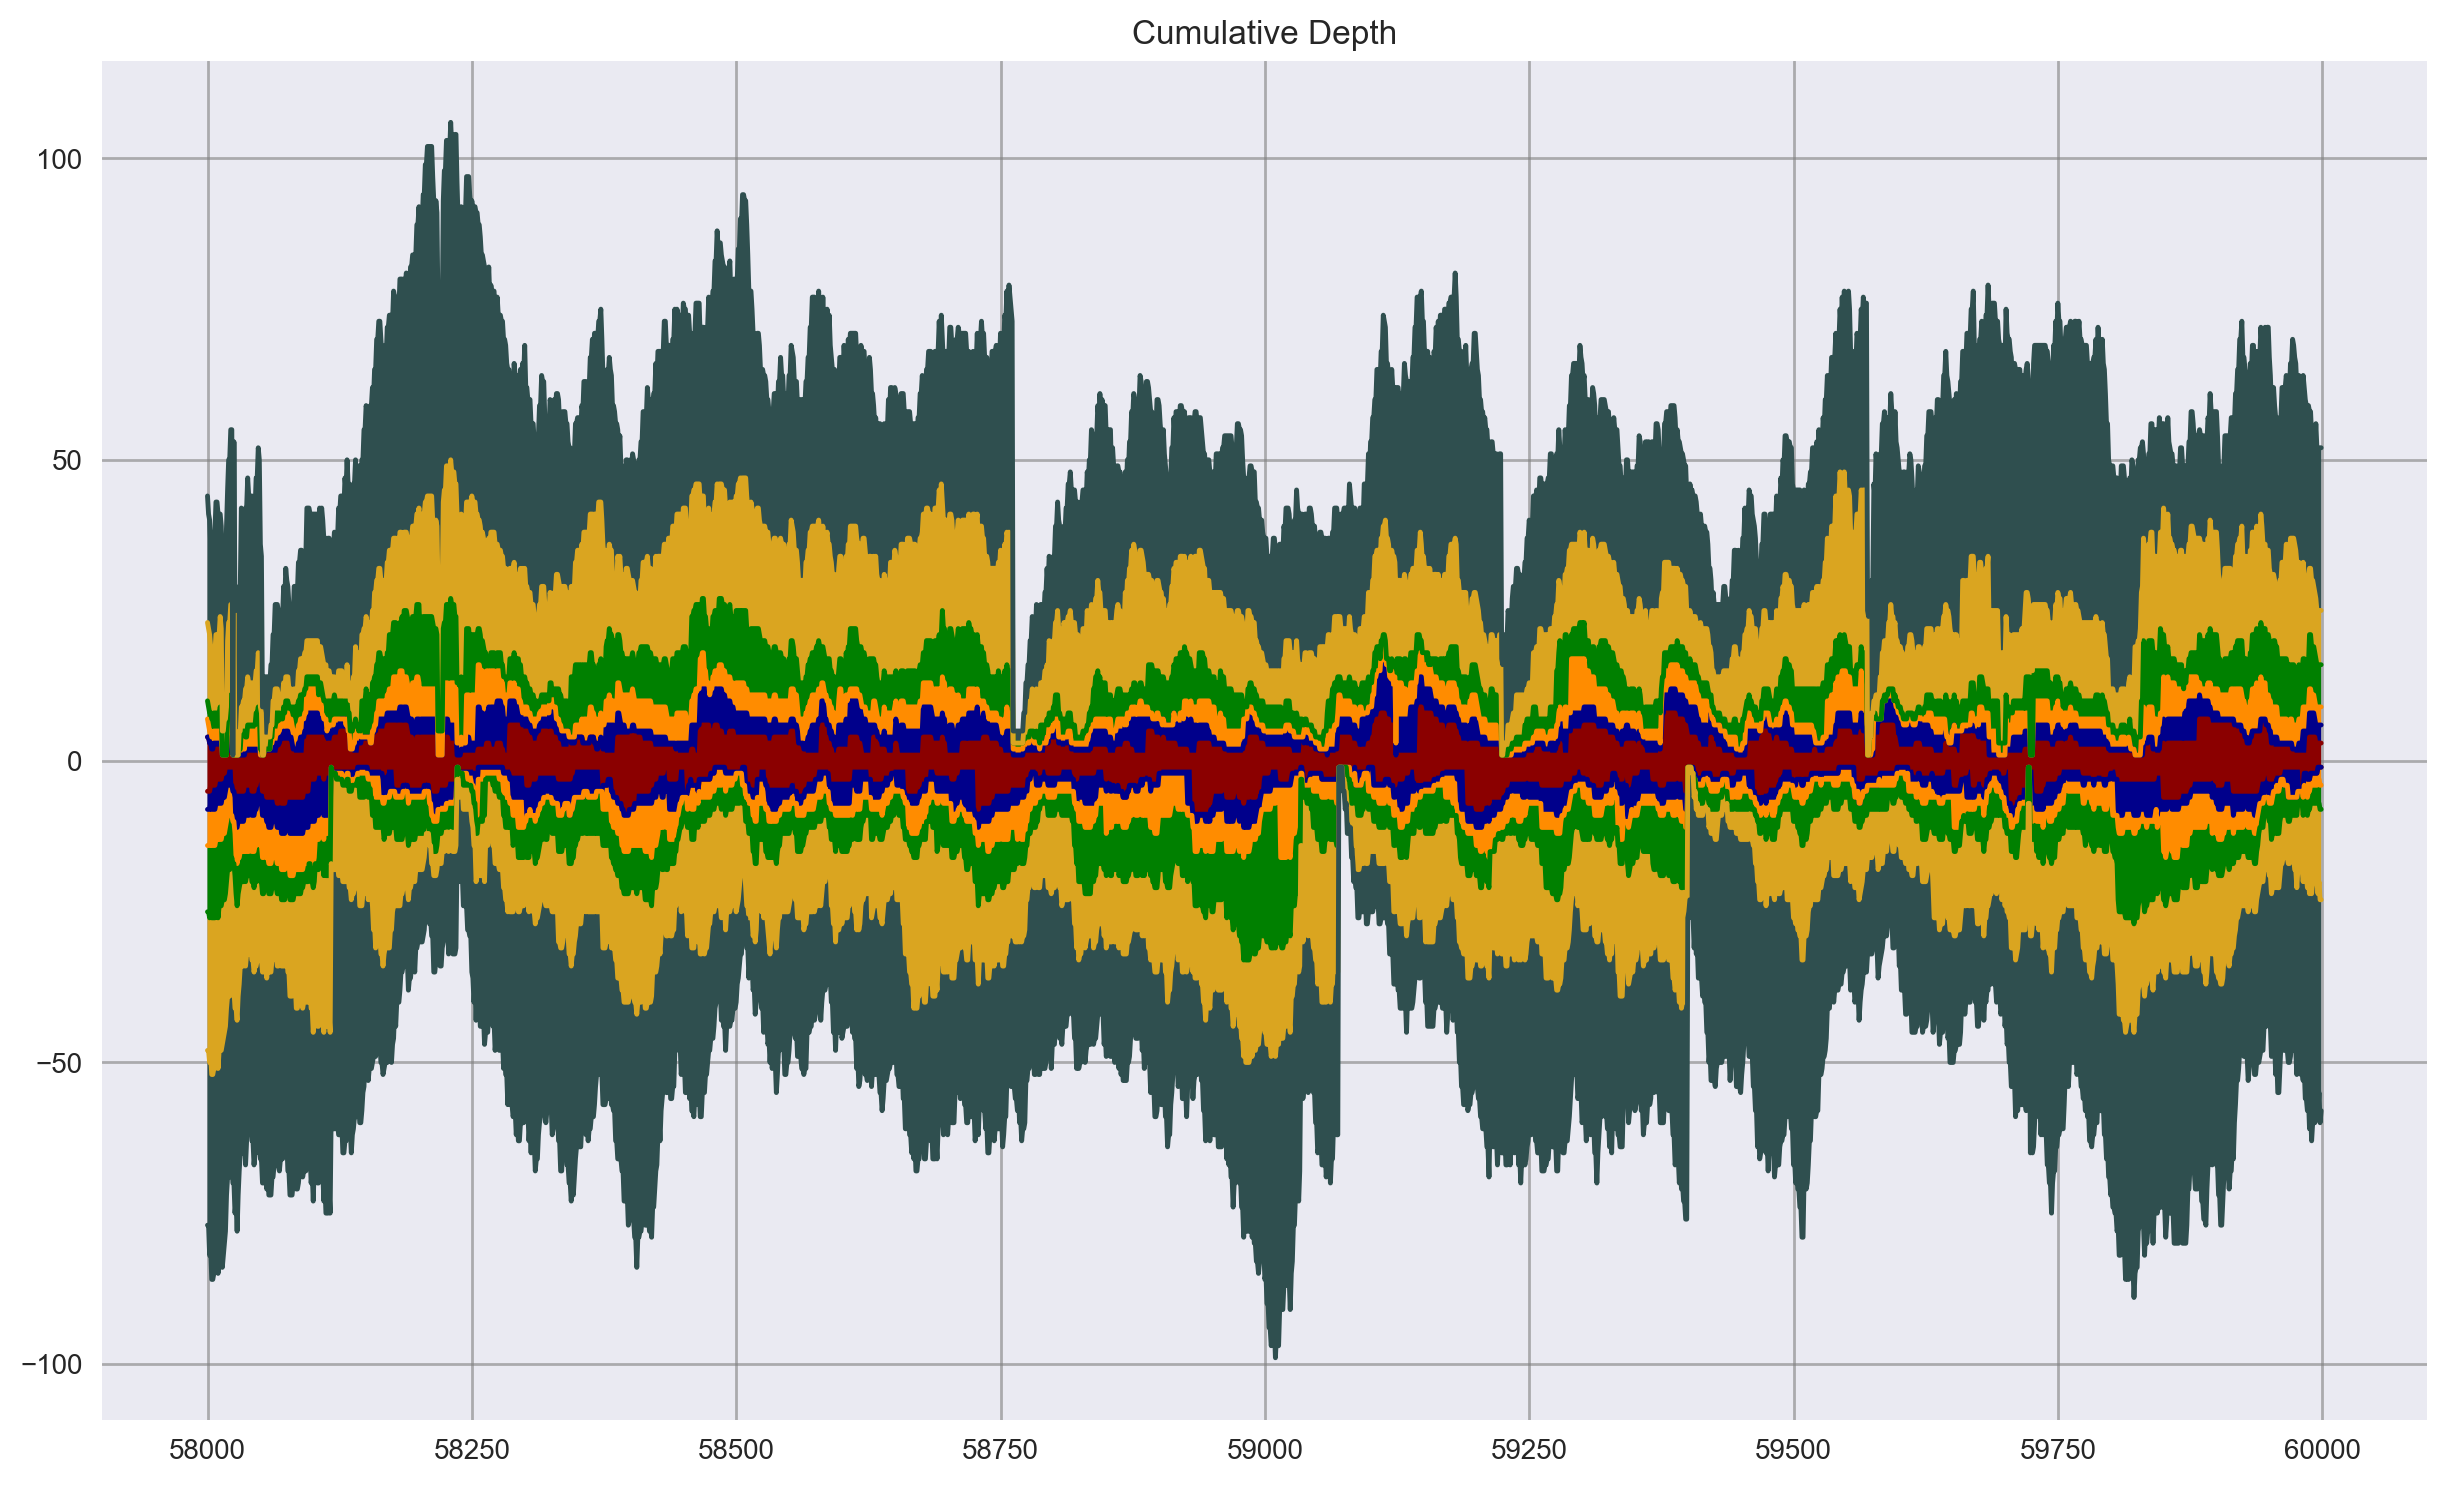

In [30]:
color_list = ['DarkRed', 'DarkBlue', 'DarkOrange', 'Green', 'Goldenrod', 'DarkSlateGray', 
              'Chartreuse' , '#FF00FF', '#FF7373', '#CFFF8C']

fig = plt.figure(figsize=(15,9), dpi=200, facecolor='w')

x_axis = [pd.to_datetime(x, unit='us') for x in bid_df.index]

ax1 = fig.add_subplot(1,1,1)
ax1.plot(bid_df.index, -bid_df.bid1, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, -bid_df.bid2, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, -bid_df.bid3, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, -bid_df.bid5, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, -bid_df.bid10, linestyle='solid', color=color_list[4], marker='None')
ax1.plot(bid_df.index, -bid_df.bid20, linestyle='solid', color=color_list[5], marker='None')
ax1.plot(bid_df.index, ask_df.ask1, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, ask_df.ask2, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, ask_df.ask3, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, ask_df.ask5, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, ask_df.ask10, linestyle='solid', color=color_list[4], marker='None')
ax1.plot(bid_df.index, ask_df.ask20, linestyle='solid', color=color_list[5], marker='None')

ax1.fill_between(bid_df.index, -bid_df.bid1, ask_df.ask1, facecolor=color_list[0], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid1, -bid_df.bid2, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid2, -bid_df.bid3, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid3, -bid_df.bid5, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid5, -bid_df.bid10, facecolor=color_list[4], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid10, -bid_df.bid20, facecolor=color_list[5], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask1, ask_df.ask2, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask2, ask_df.ask3, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask3, ask_df.ask5, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask5, ask_df.ask10, facecolor=color_list[4], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask10, ask_df.ask20, facecolor=color_list[5], interpolate=True)

ax1.grid(which='major', axis='both', color='Grey', linestyle='-', linewidth=1, alpha=0.6)
ax1.set_title('Cumulative Depth')
fig.savefig('%sjet1.png' % chartdir)
plt.show()

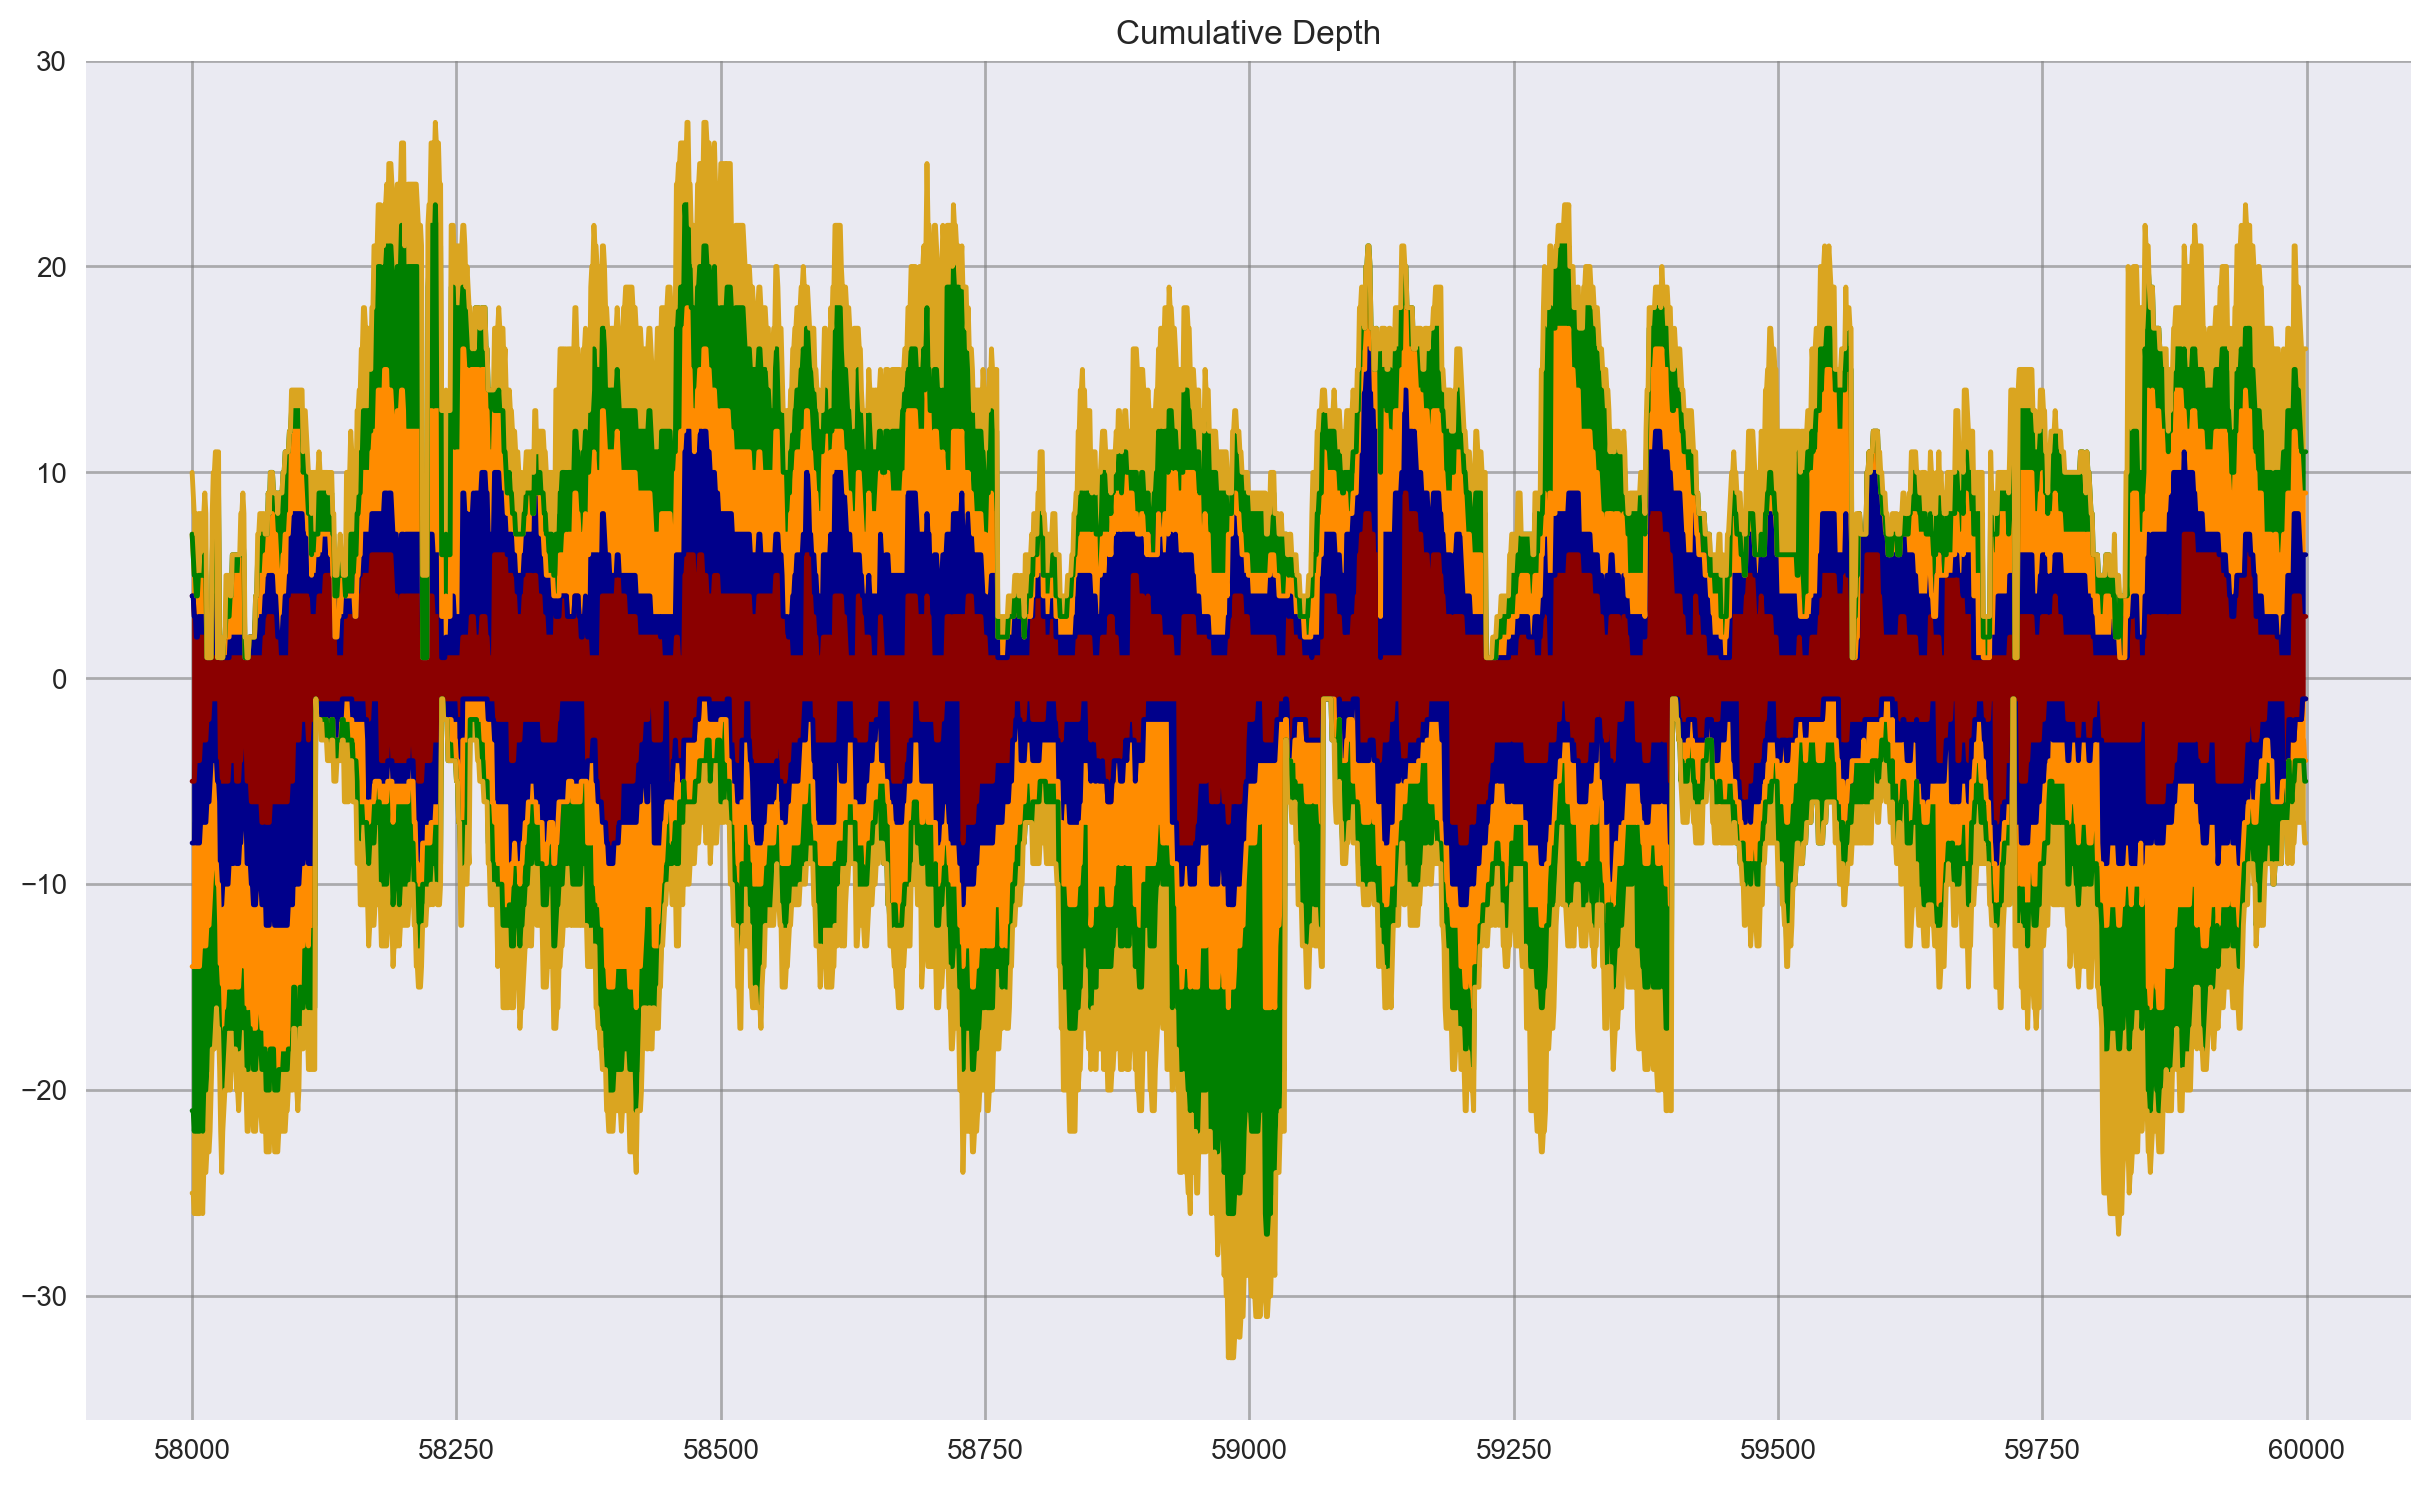

In [31]:
color_list = ['DarkRed', 'DarkBlue', 'DarkOrange', 'Green', 'Goldenrod', 'DarkSlateGray', 
              'Chartreuse' , '#FF00FF', '#FF7373', '#CFFF8C']

fig = plt.figure(figsize=(15,9), dpi=200, facecolor='w')

x_axis = [pd.to_datetime(x, unit='us') for x in bid_df.index]

ax1 = fig.add_subplot(1,1,1)
ax1.plot(bid_df.index, -bid_df.bid1, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, -bid_df.bid2, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, -bid_df.bid3, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, -bid_df.bid4, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, -bid_df.bid5, linestyle='solid', color=color_list[4], marker='None')
ax1.plot(bid_df.index, ask_df.ask1, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, ask_df.ask2, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, ask_df.ask3, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, ask_df.ask4, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, ask_df.ask5, linestyle='solid', color=color_list[4], marker='None')

ax1.fill_between(bid_df.index, -bid_df.bid1, ask_df.ask1, facecolor=color_list[0], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid1, -bid_df.bid2, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid2, -bid_df.bid3, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid3, -bid_df.bid4, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid4, -bid_df.bid5, facecolor=color_list[4], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask1, ask_df.ask2, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask2, ask_df.ask3, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask3, ask_df.ask4, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask4, ask_df.ask5, facecolor=color_list[4], interpolate=True)

ax1.grid(which='major', axis='both', color='Grey', linestyle='-', linewidth=1, alpha=0.6)
ax1.set_title('Cumulative Depth')
fig.savefig('%sjet2.png' % chartdir)
plt.show()

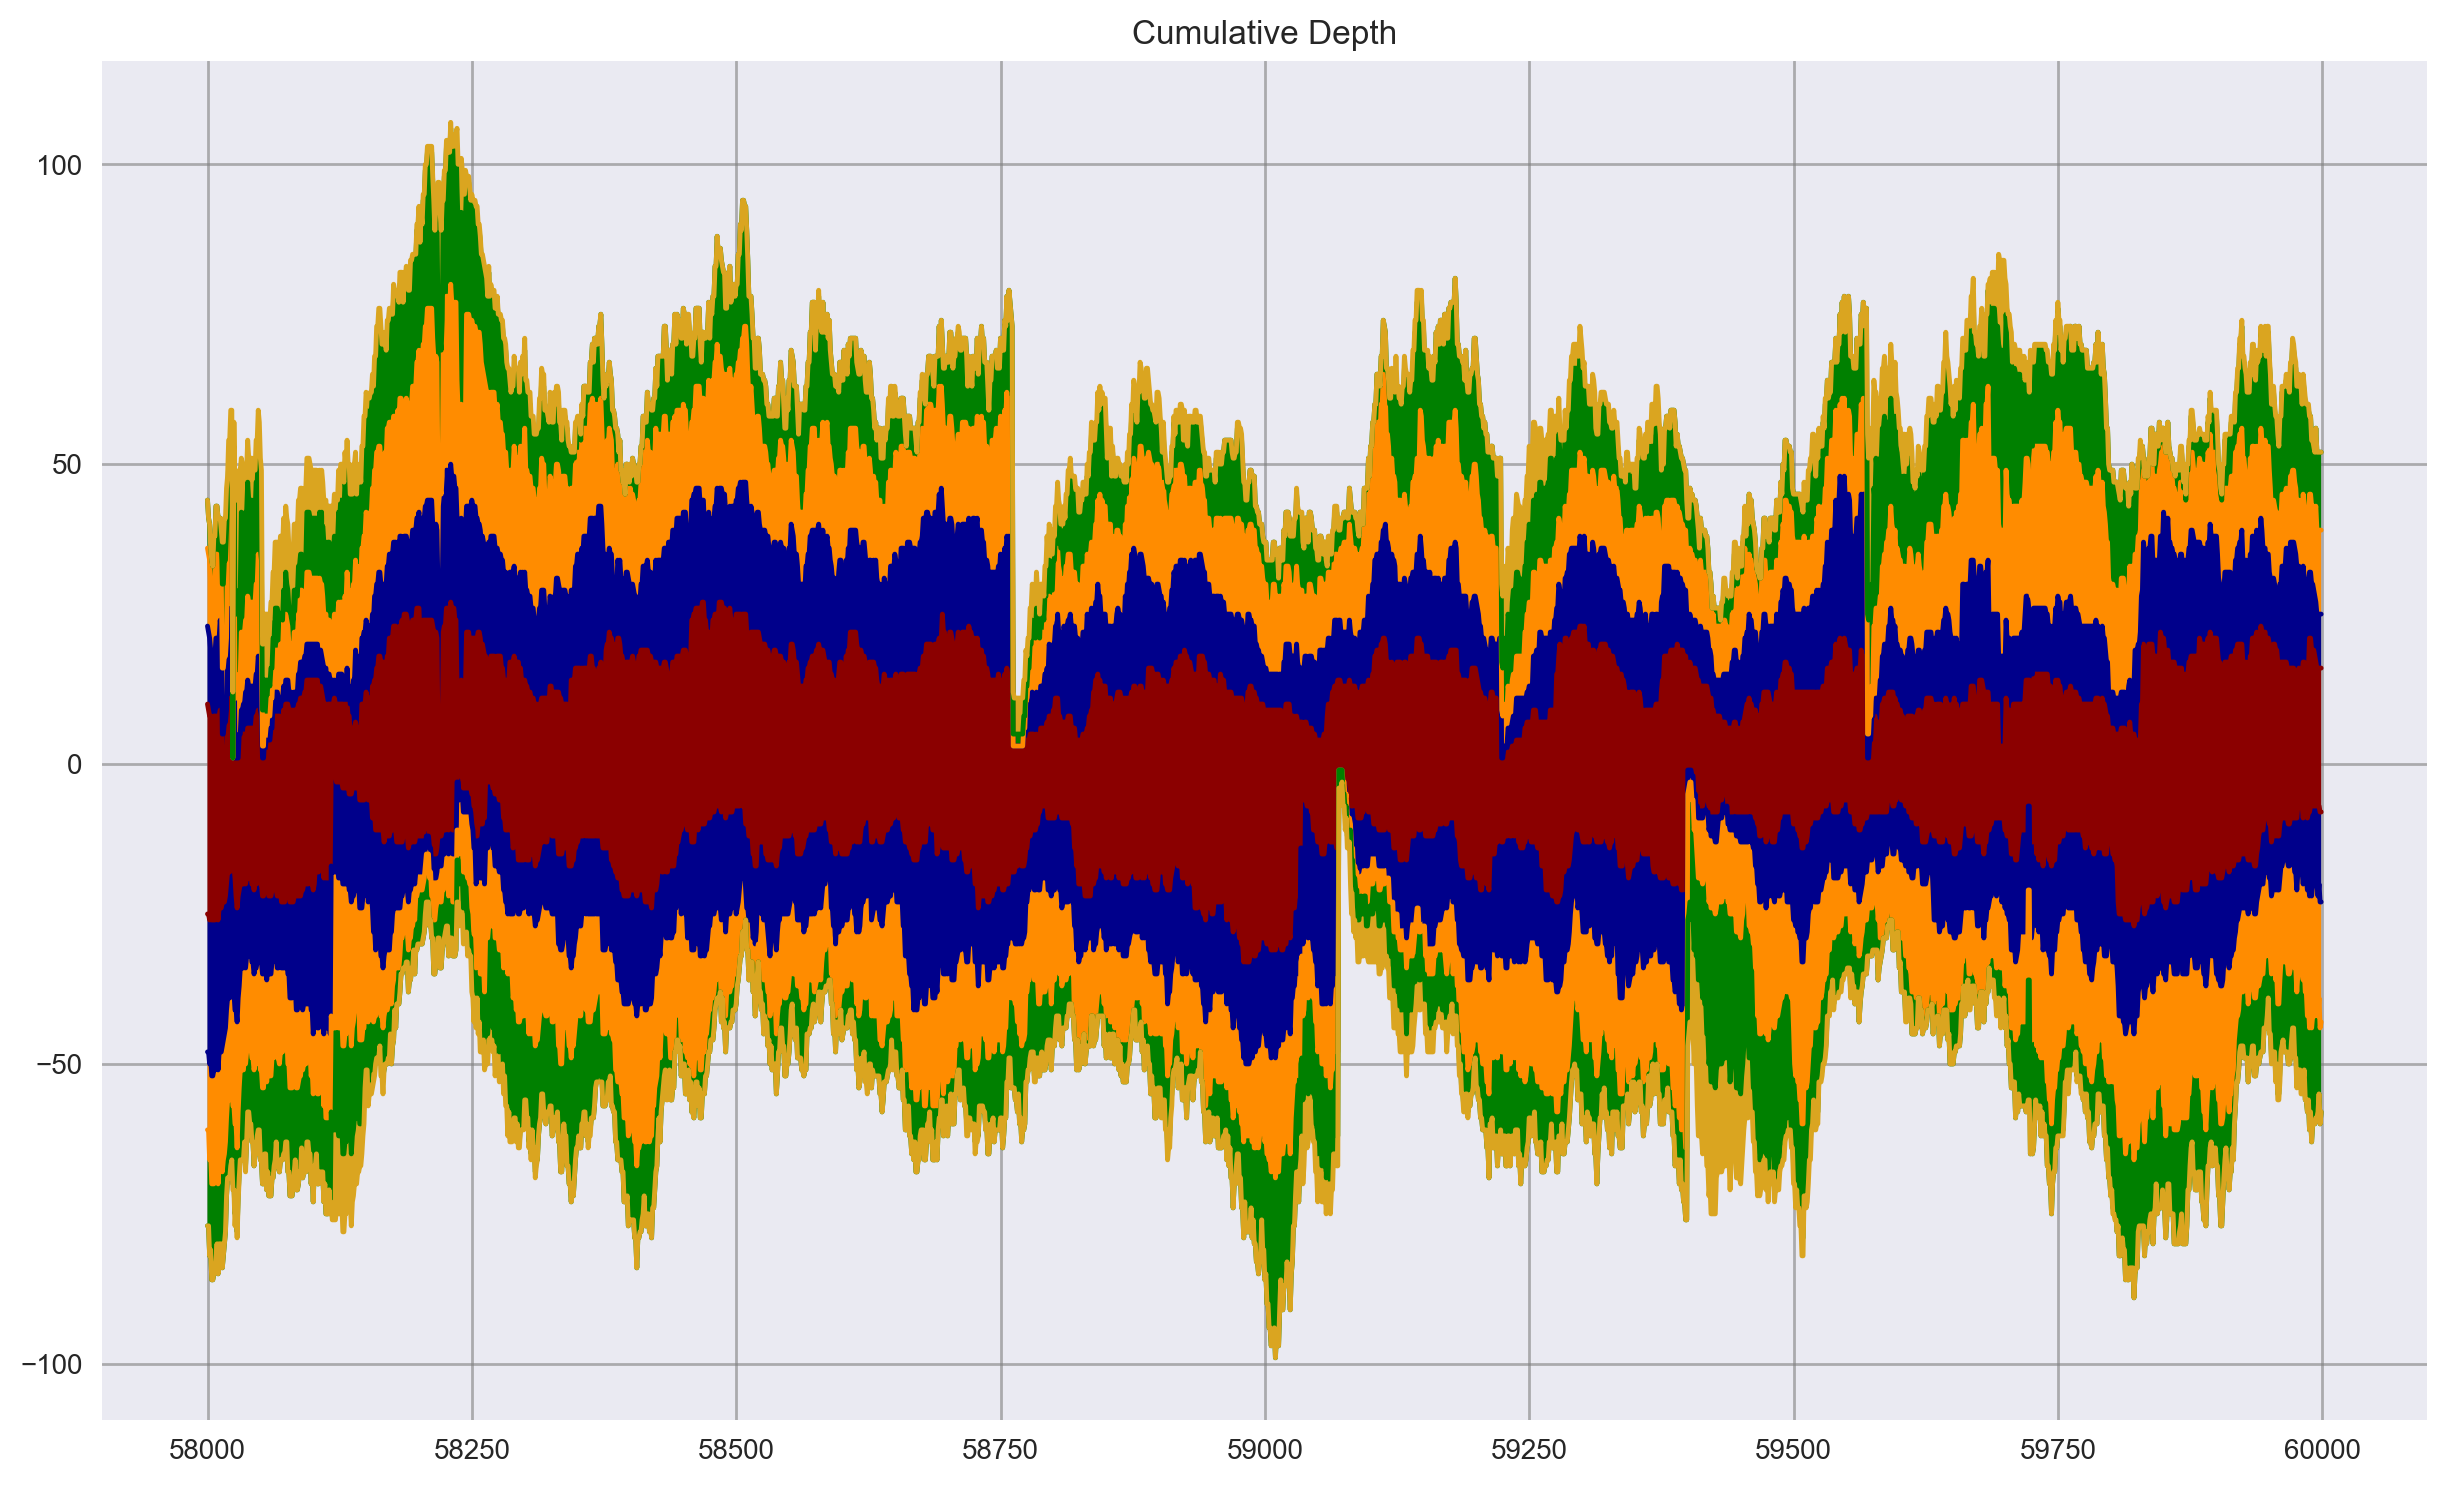

In [32]:
color_list = ['DarkRed', 'DarkBlue', 'DarkOrange', 'Green', 'Goldenrod', 'DarkSlateGray', 
              'Chartreuse' , '#FF00FF', '#FF7373', '#CFFF8C']

fig = plt.figure(figsize=(15,9), dpi=200, facecolor='w')

x_axis = [pd.to_datetime(x, unit='us') for x in bid_df.index]

ax1 = fig.add_subplot(1,1,1)
ax1.plot(bid_df.index, -bid_df.bid5, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, -bid_df.bid10, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, -bid_df.bid15, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, -bid_df.bid20, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, -bid_df.bid25, linestyle='solid', color=color_list[4], marker='None')
ax1.plot(bid_df.index, ask_df.ask5, linestyle='solid', color=color_list[0], marker='None')
ax1.plot(bid_df.index, ask_df.ask10, linestyle='solid', color=color_list[1], marker='None')
ax1.plot(bid_df.index, ask_df.ask15, linestyle='solid', color=color_list[2], marker='None')
ax1.plot(bid_df.index, ask_df.ask20, linestyle='solid', color=color_list[3], marker='None')
ax1.plot(bid_df.index, ask_df.ask25, linestyle='solid', color=color_list[4], marker='None')

ax1.fill_between(bid_df.index, -bid_df.bid5, ask_df.ask5, facecolor=color_list[0], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid5, -bid_df.bid10, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid10, -bid_df.bid15, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid15, -bid_df.bid20, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, -bid_df.bid20, -bid_df.bid25, facecolor=color_list[4], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask5, ask_df.ask10, facecolor=color_list[1], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask10, ask_df.ask15, facecolor=color_list[2], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask15, ask_df.ask20, facecolor=color_list[3], interpolate=True)
ax1.fill_between(bid_df.index, ask_df.ask20, ask_df.ask25, facecolor=color_list[4], interpolate=True)

ax1.grid(which='major', axis='both', color='Grey', linestyle='-', linewidth=1, alpha=0.6)
ax1.set_title('Cumulative Depth')
fig.savefig('%sjet3.png' % chartdir)
plt.show()